In [ ]:
!pip install catboost
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import joblib

from catboost import CatBoostClassifier
from catboost import Pool, cv

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/pet-transformator/base_pred_to_clf_trans.csv")
X = df.drop("label", axis = 1).copy()
y = df["label"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
train_pool = Pool(data=x_train, label=y_train)
eval_pool = Pool(data=x_test, label=y_test)
scal = StandardScaler()
x_train_scaled = scal.fit_transform(x_train)
x_test_scaled = scal.transform(x_test)
print(df.shape)
print(x_train.shape)
print(x_train_scaled.shape)

(2100, 53)
(1680, 52)
(1680, 52)


In [35]:

MLP_best1 = joblib.load("/content/gdrive/MyDrive/pet-transformator/Ensembling_ML/MLP_base_best2.pkl") # (40,) tanh (Scaled)
MLP_best2 = joblib.load("/content/gdrive/MyDrive/pet-transformator/Ensembling_ML/MLP_base_best3.pkl") # (9,) relu  (Scaled)

rf_basedf = joblib.load("/content/gdrive/MyDrive/pet-transformator/Ensembling_ML/RF_clf_basedf_best.pkl") # Все признаки (Scaled)

cat_alldf = CatBoostClassifier().load_model('/content/gdrive/MyDrive/pet-transformator/CatBoost_Tunning/Tuned_Cat_clf_allf(Best1).cbm',
           format="cbm")
cat_fs = CatBoostClassifier().load_model('/content/gdrive/MyDrive/pet-transformator/CatBoost_Tunning/Tuned_Cat_clf_38f_with_select_feature(Best2).cbm',
           format="cbm")



In [38]:
MLP_best1_param_dict = MLP_best1.get_params()
MLP_best2_param_dict = MLP_best2.get_params()
rf_basedf_param_dict = rf_basedf.get_params()
cat_alldf_param_dict = cat_alldf.get_params()
cat_fs_param_dict = cat_fs.get_params()
print('MLP_(40,)'),print(MLP_best1_param_dict),print('###########')
print('MLP_(9,)'),print(MLP_best2_param_dict),print('###########')
print('RF_alldf'),print(rf_basedf_param_dict),print('###########')
print('CatBoost_alldf'),print(cat_alldf_param_dict),print('###########')
print('CatBoost_fs'),print(cat_fs_param_dict),print('###########')


MLP_(40,)
{'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (40,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 20, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': True, 'warm_start': False}
###########
MLP_(9,)
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (9,), 'learning_rate': 'constant', 'learning_rate_init': 0.015, 'max_fun': 15000, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 30, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': True, 'warm_start': False}
###########

(None, None, None)

# **Stacked Classifier**

In [9]:
clf1 = RandomForestClassifier(**rf_basedf_param_dict).set_params(verbose=0)
clf2 = MLPClassifier(**MLP_best1_param_dict).set_params(verbose=0)
meta_clf = CatBoostClassifier(**cat_alldf_param_dict).set_params(od_wait=70, verbose=0)
sclf = StackingClassifier(classifiers=[clf1, clf2], 
                      meta_classifier = meta_clf)

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.94      0.70      0.80        23
           4       0.81      0.76      0.78        38

    accuracy                           0.95       420
   macro avg       0.90      0.81      0.85       420
weighted avg       0.95      0.95      0.95       420



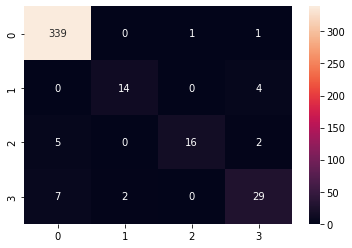

In [10]:
sclf.fit(x_train, y_train)

y_pred = sclf.predict(x_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test,sclf.predict(x_test)), annot=True, fmt="1")

In [11]:
clf1 = RandomForestClassifier(**rf_basedf_param_dict).set_params(verbose=0)
clf2 = MLPClassifier(**MLP_best1_param_dict).set_params(verbose=0)
meta_clf = CatBoostClassifier(**cat_fs_param_dict).set_params(od_wait=70, verbose=0)
sclf = StackingClassifier(classifiers=[clf1, clf2], 
                      meta_classifier = meta_clf)

              precision    recall  f1-score   support

           1       0.96      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.94      0.70      0.80        23
           4       0.78      0.74      0.76        38

    accuracy                           0.94       420
   macro avg       0.89      0.80      0.84       420
weighted avg       0.94      0.94      0.94       420



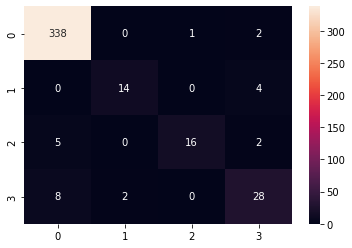

In [12]:
sclf.fit(x_train, y_train)

y_pred = sclf.predict(x_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test,sclf.predict(x_test)), annot=True, fmt="1")

              precision    recall  f1-score   support

           1       0.96      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.94      0.70      0.80        23
           4       0.78      0.74      0.76        38

    accuracy                           0.94       420
   macro avg       0.89      0.80      0.84       420
weighted avg       0.94      0.94      0.94       420



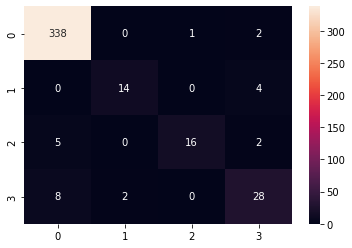

In [13]:
clf1 = RandomForestClassifier(**rf_basedf_param_dict).set_params(verbose=0)
clf2 = MLPClassifier(**MLP_best2_param_dict).set_params(verbose=0)
meta_clf = CatBoostClassifier(**cat_fs_param_dict).set_params(od_wait=70, verbose=0)
sclf = StackingClassifier(classifiers=[clf1, clf2], 
                      meta_classifier = meta_clf)
sclf.fit(x_train, y_train)

y_pred = sclf.predict(x_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test,sclf.predict(x_test)), annot=True, fmt="1")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

              precision    recall  f1-score   support

           1       0.96      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.94      0.70      0.80        23
           4       0.80      0.74      0.77        38

    accuracy                           0.95       420
   macro avg       0.89      0.80      0.84       420
weighted avg       0.94      0.95      0.94       420



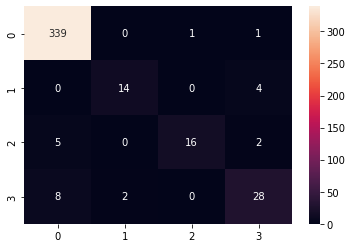

In [15]:
clf1 = RandomForestClassifier(**rf_basedf_param_dict).set_params(verbose=0)
clf2 = MLPClassifier(**MLP_best2_param_dict).set_params(verbose=0)
meta_clf = CatBoostClassifier(**cat_alldf_param_dict).set_params(od_wait=70, verbose=0)
sclf = StackingClassifier(classifiers=[clf1, clf2], 
                      meta_classifier = meta_clf)
sclf.fit(x_train, y_train)

y_pred = sclf.predict(x_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test,sclf.predict(x_test)), annot=True, fmt="1")

In [19]:
cat_alldf.fit(x_train, y_train)

y_pred = cat_alldf.predict(x_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,cat_alldf.predict(x_test)))

cat_fs.fit(x_train, y_train)

y_pred = cat_fs.predict(x_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,cat_fs.predict(x_test)))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.95      0.78      0.86        23
           4       0.81      0.76      0.78        38

    accuracy                           0.95       420
   macro avg       0.90      0.83      0.86       420
weighted avg       0.95      0.95      0.95       420

[[339   0   0   2]
 [  0  14   0   4]
 [  4   0  18   1]
 [  6   2   1  29]]
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.93      0.78      0.85        18
           3       0.95      0.78      0.86        23
           4       0.79      0.79      0.79        38

    accuracy                           0.95       420
   macro avg       0.91      0.84      0.87       420
weighted avg       0.95      0.95      0.95       420

[[339   0   0   2]
 [  0  14   0   4]
 [  3   0  18  

Sracking clf не показал положительных результатов.

Лучшей моделью пока является CatBoost с отобранными признаками.

# **VotingClassifier**

In [34]:
clf1 = RandomForestClassifier(**rf_basedf_param_dict).set_params(verbose=0)
clf2 = MLPClassifier(**MLP_best1_param_dict).set_params(verbose=0)
clf3 = CatBoostClassifier(**cat_alldf_param_dict).set_params(od_wait=70, verbose=0)
eclf = VotingClassifier(
     estimators=[('rf', clf1), ('mlp', clf2), ('cb', clf3)],
     voting='soft')
eclf.fit(x_train, y_train)
y_pred = eclf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print('####################')

clf1 = RandomForestClassifier(**rf_basedf_param_dict).set_params(verbose=0)
clf2 = MLPClassifier(**MLP_best2_param_dict).set_params(verbose=0)
clf3 = CatBoostClassifier(**cat_alldf_param_dict).set_params(od_wait=70, verbose=0)
eclf = VotingClassifier(
     estimators=[('rf', clf1), ('mlp', clf2), ('cb', clf3)],
     voting='soft')
eclf.fit(x_train, y_train)
y_pred = eclf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print('####################')

clf1 = RandomForestClassifier(**rf_basedf_param_dict).set_params(verbose=0)
clf2 = MLPClassifier(**MLP_best1_param_dict).set_params(verbose=0)
clf3 = CatBoostClassifier(**cat_fs_param_dict).set_params(od_wait=70, verbose=0)
eclf = VotingClassifier(
     estimators=[('rf', clf1), ('mlp', clf2), ('cb', clf3)],
     voting='soft')
eclf.fit(x_train, y_train)
y_pred = eclf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print('####################')

clf1 = RandomForestClassifier(**rf_basedf_param_dict).set_params(verbose=0)
clf2 = MLPClassifier(**MLP_best2_param_dict).set_params(verbose=0)
clf3 = CatBoostClassifier(**cat_fs_param_dict).set_params(od_wait=70, verbose=0)
eclf = VotingClassifier(
     estimators=[('rf', clf1), ('mlp', clf2), ('cb', clf3)],
     voting='soft')
eclf.fit(x_train, y_train)
y_pred = eclf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print('####################')

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       1.00      0.70      0.82        23
           4       0.78      0.76      0.77        38

    accuracy                           0.95       420
   macro avg       0.91      0.81      0.85       420
weighted avg       0.95      0.95      0.95       420

[[339   0   0   2]
 [  0  14   0   4]
 [  5   0  16   2]
 [  7   2   0  29]]
####################
              precision    recall  f1-score   support

           1       0.96      1.00      0.98       341
           2       0.93      0.78      0.85        18
           3       0.94      0.65      0.77        23
           4       0.80      0.74      0.77        38

    accuracy                           0.95       420
   macro avg       0.91      0.79      0.84       420
weighted avg       0.94      0.95      0.94       420

[[340   0   0   1]
 [  0  14   0

При применении Voting Classifier в некоторых комбинациях уменьшается количество пропущенных дефектов, но сильно увеличивается количество ложных срабатываний.

В качестве рабочей модели машинного обучения будем в дальнейшем использовать самостоятельный CatBoost с отбором признаков.